In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import rand_score, calinski_harabasz_score, mutual_info_score, accuracy_score
from sklearn.cluster import KMeans
import itertools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.metrics import AUC,Precision,Recall,BinaryCrossentropy,Accuracy
import networkx as nx
import torch
from torch_geometric.utils import *
from torch import Tensor
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('Not found')
print('Found GPU at: {}'.format(device_name))

2022-10-03 12:32:01.874317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 12:32:10.256609: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-03 12:32:10.256646: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-03 12:32:11.299557: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-03 12:32:18.808055: W tensorflow/stream_executor/platform/de

Not found
Found GPU at: 


2022-10-03 12:32:38.904932: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 12:32:39.013537: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-03 12:32:39.018483: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-03 12:32:39.018529: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (felipe-Inspiron-5448): /proc/driver/nvidia/version does not exist


In [3]:
m0 = (1,0)
m1 = (np.cos(2*np.pi/3),np.sin(2*np.pi/3))
m2 = (np.cos(-2*np.pi/3),np.sin(-2*np.pi/3))
basis = [m0,m1,m2]

In [4]:
K = 3
n = 100

In [5]:
def make_vectors(basis,K,n,sigma):
    X = np.zeros((K*n,2))
    for c in range(K): ## PARA CADA UMA DAS COMUNIDADES
        for i in range(n):## PARA CADA VÉRTICE DE UMA COMUNIDADE
            X[i+n*c][:] = np.random.multivariate_normal(basis[c],np.diag([sigma]*2))
    return X

In [6]:
def make_plot(X_t,title,sigma,folder,n=n,kmeans_centers=None):
    plt.scatter(X_t[:n,0],X_t[:n,1],label="1")
    plt.scatter(X_t[n:2*n,0],X_t[n:2*n,1],label="2")
    plt.scatter(X_t[2*n:3*n,0],X_t[2*n:3*n,1],label="3")
    if kmeans_centers is not None:
        plt.scatter(kmeans_centers[:,0],kmeans_centers[:,1],label="centroid",color="black")
    plt.legend()
    plt.title(title)
    plt.savefig(folder+"/embedding_"+title+f"_sigma_{sigma}.png")
    plt.show()

In [7]:
def acc(x,y):
    if len(x) != len(y):
        raise ValueError('x and y must be arrays of the same size')
    N = len(x)
    scores = []
    possible_combinations = list(itertools.permutations(np.unique(x)))
    for combination in possible_combinations:
        pred = np.array([combination[i] for i in x])
        scores.append(accuracy_score(y,pred))
        print(combination)
    score = max(scores)
    return score

In [20]:
## Teste
X = make_vectors(basis,K,n,4)
with open('attributes.npy', 'wb') as f:
    np.save(f, X)
#probs = [[0.25, 0.05, 0.02], [0.05, 0.35, 0.07], [0.02, 0.07, 0.40]]
probs = np.ones((K,K))*0.01
for i in range(K):
    probs[i,i] = 0.1
g = nx.stochastic_block_model([n,n,n], probs, seed=0)
nx.write_adjlist(g, "network.adjlist")

---------------- SIGMA = 0.1 -------------------


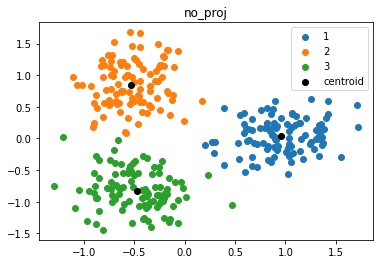

/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


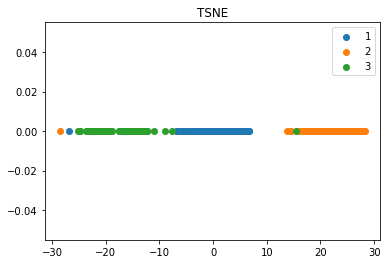

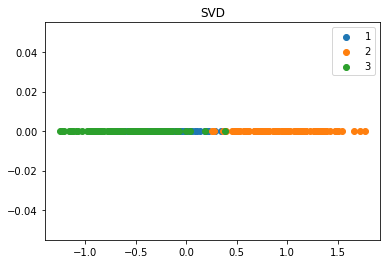

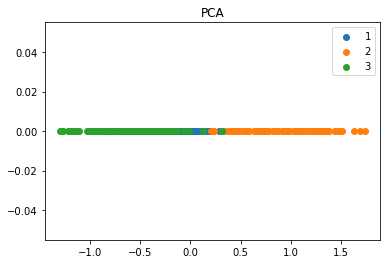

(0, 1, 2)
(0, 2, 1)
(1, 0, 2)
(1, 2, 0)
(2, 0, 1)
(2, 1, 0)
---------------- SIGMA = 0.25 -------------------


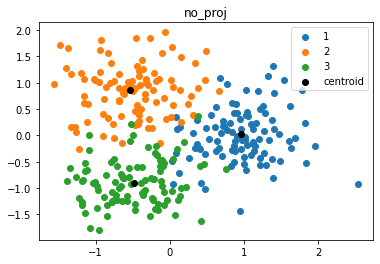

/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


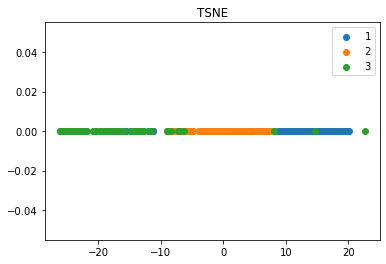

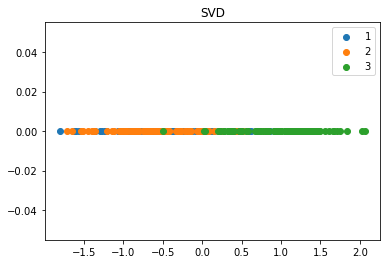

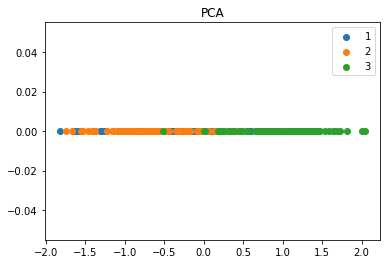

(0, 1, 2)
(0, 2, 1)
(1, 0, 2)
(1, 2, 0)
(2, 0, 1)
(2, 1, 0)
---------------- SIGMA = 0.5 -------------------


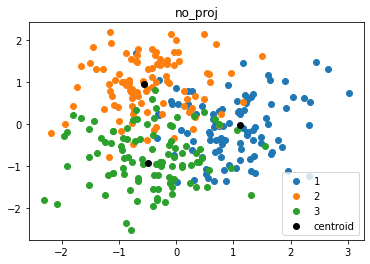

/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


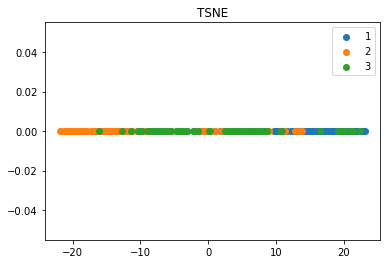

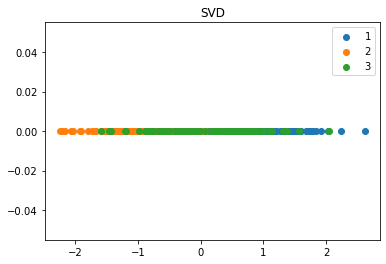

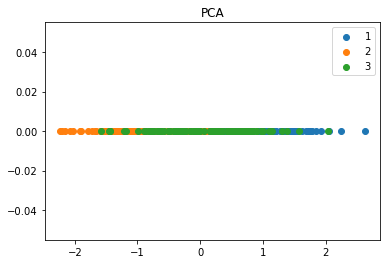

(0, 1, 2)
(0, 2, 1)
(1, 0, 2)
(1, 2, 0)
(2, 0, 1)
(2, 1, 0)
---------------- SIGMA = 0.75 -------------------


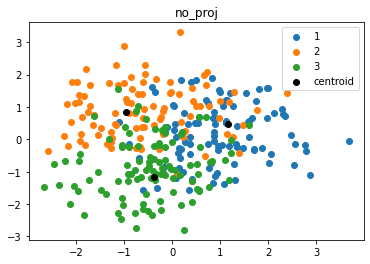

/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


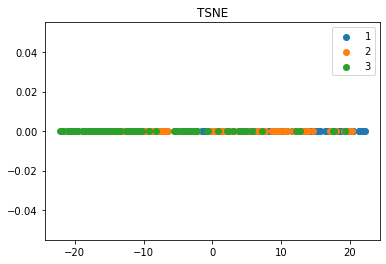

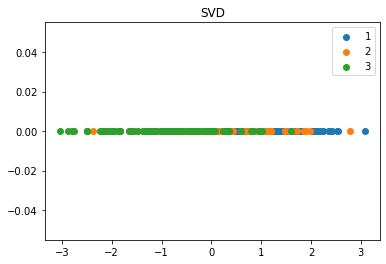

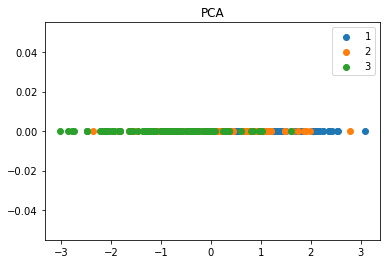

(0, 1, 2)
(0, 2, 1)
(1, 0, 2)
(1, 2, 0)
(2, 0, 1)
(2, 1, 0)
---------------- SIGMA = 1.0 -------------------


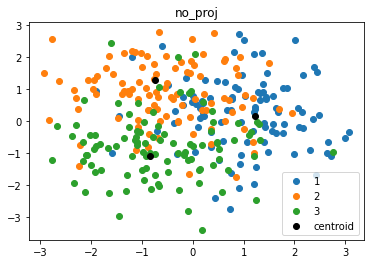

/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


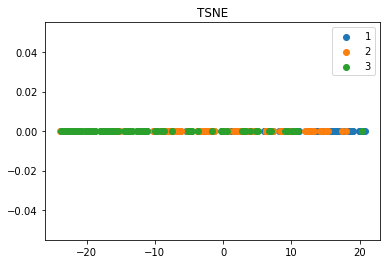

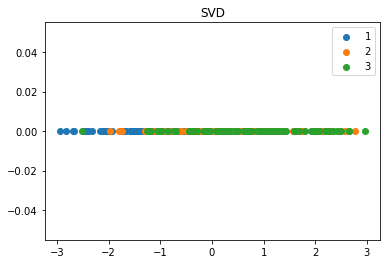

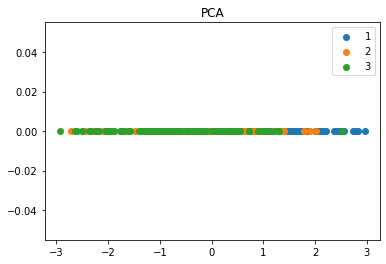

(0, 1, 2)
(0, 2, 1)
(1, 0, 2)
(1, 2, 0)
(2, 0, 1)
(2, 1, 0)
---------------- SIGMA = 2.0 -------------------


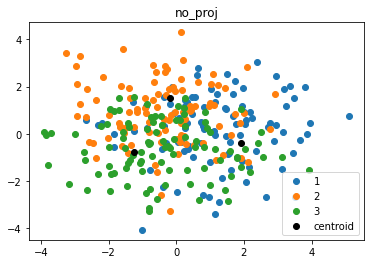

/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


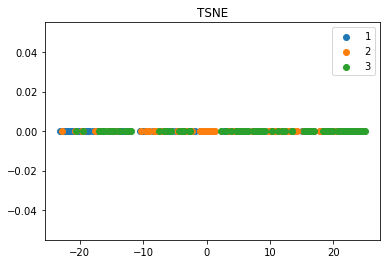

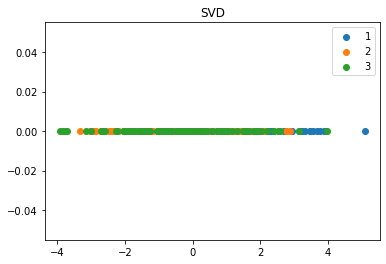

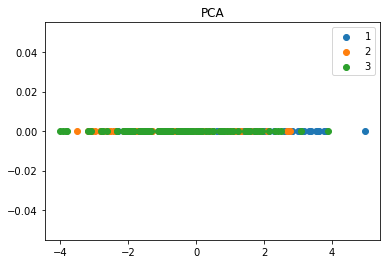

(0, 1, 2)
(0, 2, 1)
(1, 0, 2)
(1, 2, 0)
(2, 0, 1)
(2, 1, 0)
---------------- SIGMA = 4.0 -------------------


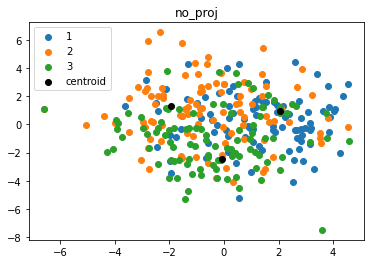

/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felipe/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


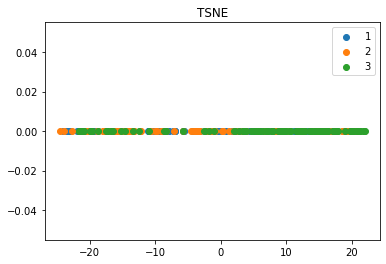

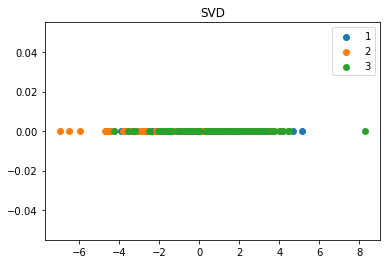

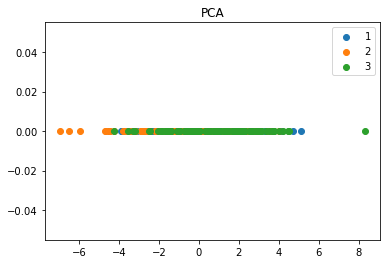

(0, 1, 2)
(0, 2, 1)
(1, 0, 2)
(1, 2, 0)
(2, 0, 1)
(2, 1, 0)


In [7]:
def run_test(basis,K,n,make_vectors,folder):
    sigmas = np.array([0.1, 0.25, 0.5, 0.75, 1, 2, 4])
    exists = os.path.exists("./"+folder)
    if not exists:
        os.mkdir("./"+folder)
    true_labels = [0]*n + [1]*n + [2]*n
    with open("metrics.txt",'w',encoding = 'utf-8') as f:
        for sigma in sigmas:
            print(f"---------------- SIGMA = {sigma} -------------------")
            X = make_vectors(basis,K,n,sigma)
            kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
            make_plot(X,"no_proj",sigma,folder,kmeans_centers=kmeans.cluster_centers_)
            X_t = TSNE(n_components=1).fit_transform(X)
            X_t = np.column_stack([X_t[:,0],np.zeros(X_t.shape[0])])
            make_plot(X_t,"TSNE",sigma,folder)
            X_t = TruncatedSVD(n_components=1).fit_transform(X)
            X_t = np.column_stack([X_t[:,0],np.zeros(X_t.shape[0])])
            make_plot(X_t,"SVD",sigma,folder)
            X_t = PCA(n_components=1).fit_transform(X)
            X_t = np.column_stack([X_t[:,0],np.zeros(X_t.shape[0])])
            make_plot(X_t,"PCA",sigma,folder)
            rs = rand_score(true_labels, kmeans.labels_)
            acc_ = acc(true_labels, kmeans.labels_)
            mi = mutual_info_score(true_labels, kmeans.labels_)
            ch = calinski_harabasz_score(X, kmeans.labels_)
            f.write(f"--- sigma_{sigma} ---\n")
            f.write(f"    acc {acc_:.2f}\n")
            f.write(f"    rand index {rs:.2f}\n")
            f.write(f"    mutual info {mi:.2f}\n")
            f.write(f"    calinski_harabasz {ch:.2f}\n")
run_test(basis,K,n,make_vectors,"Teste4")